In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np

In [30]:


def getTimesThputs(file):
    f = open(file, "r")
    data = f.readlines() 
    times = []
    thputs = []
    latencies = []
    for line in data:
        if not line.startswith('--') and 'current ops/sec; [UPDATE AverageLatency' in line:

#         print(line)
            times.append(line.split('sec:')[0].strip())
            thputs.append(line.split(';')[1].split('current')[0].strip())
            latencies.append(line.split('=')[1].split(']')[0].strip())

    return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)  






def getTimeThps(file, flag):
    
    f = open(file, "r")
    data = f.readlines() 

    times = []
    thputs = []
    for line in data:
        if 'throughput[ops/s]' in line:
            lineData = (line[13+line.find('max[ops/s])>'):-2])
            print(lineData)

            times.append(lineData.split('|')[0])
            thputs.append(lineData.split('|')[-2])
    if (flag): 
        times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
        thputs.append(0)
        
    return np.array(times).astype(float), np.array(thputs).astype(float) 

In [2]:
os.system("aws --region us-west-1 ec2 describe-instances  --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

os.system("aws --region us-west-1 ec2 describe-instances --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")

0

In [3]:
with open('all_external_ips') as f:
    lines = f.read().splitlines()


lines = [x for x in lines if x!='None']
lines, len(lines)

(['18.144.31.30',
  '13.57.193.25',
  '54.177.218.23',
  '3.101.83.7',
  '50.18.227.20',
  '54.177.190.239',
  '50.18.65.44',
  '54.241.187.86',
  '54.241.187.106',
  '204.236.161.216'],
 10)

In [4]:
for ip in lines:
    if ip!='None':
        current = (ip.split('.'))

        print('ssh -i "FinalKeys.pem" ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

ssh -i "FinalKeys.pem" ubuntu@ec2-18-144-31-30.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-57-193-25.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-54-177-218-23.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-101-83-7.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-50-18-227-20.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-54-177-190-239.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-50-18-65-44.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-54-241-187-86.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-54-241-187-106.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-204-236-161-216.us-west-1.compute.amazonaws.com


In [5]:
## Set number of clusters

nclusters = 0

for folder in os.listdir('.'):
    if 'config' in folder and folder!='config':
        nclusters = nclusters + 1
        
        
print(nclusters)


total_count = 8


nreplicas = int(total_count/nclusters)
nodeIps = lines[:nclusters* nreplicas]

# no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
no_cluster_yet_nodes = lines[nclusters* nreplicas:-2]



# clientIps = lines[-(nclusters):]
clientIps = lines[-2:]



clientIps, no_cluster_yet_nodes

2


(['54.241.187.106', '204.236.161.216'], [])

In [6]:
## Functions

def setup(i):

    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 1234 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:commands.sh'
        
        print(command)
        os.system(command)
        
def initialize(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 1234 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "sudo sh commands.sh"'
        
        
        os.system(command)
        
        
def git_clone(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t " sudo git clone https://github.com/tmane002/BftSmart_Final.git"'
        
        
        os.system(command)
        
def git_pull(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "git config --global --add safe.directory /home/ubuntu/BftSmart_Final; cd BftSmart_Final; sudo git pull"'
        
        
        os.system(command)
        
def compile_job(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo ./gradlew installDist"'
        
        
        os.system(command)

        
        
def clean_job(i):
    ip = lines[i]
    
    rm_command = 'sudo rm config/currentView; '
    for iter_ in range(nclusters):
        rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '
        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; cd BftSmart_Final; '+rm_command+'"'
        
        
        os.system(command)
        
        
def clean_all(i):
    ip = lines[i]
    
    rm_command = 'sudo rm -r BftSmart_Final; sudo rm nohup.out;sudo rm nohup_client.out;'

        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; '+rm_command+'"'
        
        
        os.system(command)
        
def run_server_node(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)
        
        
        
    if ip!='None' and( ip in no_cluster_yet_nodes):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)        
#         print(command)

def check_node(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -f -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "tail -n 1000 nohup.out"'
        
        
        os.system(command)
#         print(command)


def run_basic_client(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
#     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
        current = (ip.split('.'))
        
#         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'

        
        os.system(command)


def kill_java(i):
    ip = lines[i]
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)
        
        
        
def kill_clients(i):
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)

def run_server_node_check(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        print(command)
        
        

# for i in range(len(lines)):
#     run_server_node_check(i)

def run_basic_client_check(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'

        
        print(command)

In [ ]:
# for i in range(len(lines)):
#     run_basic_client_check(i)
    

# def setup(i):

#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:commands.sh'
        
        
#         os.system(command)
        
# def initialize(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "sudo sh commands.sh"'
        
        
#         os.system(command)
        
        
# def git_clone(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t " sudo git clone https://tmane002@bitbucket.org/tmane002/BftSmart_Final.git"'
        
        
#         os.system(command)
        
# def git_pull(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "git config --global --add safe.directory /home/ubuntu/bftsmartt; cd bftsmartt; sudo git pull"'
        
        
#         os.system(command)
        
# def compile_job(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo ./gradlew installDist"'
        
        
#         os.system(command)

        
        
# def clean_job(i):
#     ip = lines[i]
    
#     rm_command = 'sudo rm config/currentView; '
#     for iter_ in range(nclusters):
#         rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '
        
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; cd bftsmartt; '+rm_command+'"'
        
        
#         os.system(command)
        
        
# def clean_all(i):
#     ip = lines[i]
    
#     rm_command = 'sudo rm -r bftsmartt; sudo rm nohup.out;sudo rm nohup_client.out;'

        
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; '+rm_command+'"'
        
        
#         os.system(command)
        
# def run_server_node(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
#     if ip!='None' and( ip in nodeIps):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         os.system(command)
        
        
        
#     if ip!='None' and( ip in no_cluster_yet_nodes):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         os.system(command)        
# #         print(command)

# def check_node(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -f -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "tail -n 1000 nohup.out"'
        
        
#         os.system(command)
# #         print(command)


# def run_basic_client(i):
#     cmd_arg = ''
    
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
# #     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
#         current = (ip.split('.'))
        
# #         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
#         for iter__ in range(len(clientIps)):
#             if ip==clientIps[iter__]:
#                 cmd_arg = iter__
                
                
        
# #         print(i, cmd_arg)
            
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'

        
#         os.system(command)


# def kill_java(i):
#     ip = lines[i]
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo killall java; sudo killall nohup"'
        
        
#         os.system(command)
        
        
        
# def kill_clients(i):
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo killall java; sudo killall nohup"'
        
        
#         os.system(command)

# def run_server_node_check(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
#     if ip!='None' and( ip in nodeIps):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         print(command)
        
        

# # for i in range(len(lines)):
# #     run_server_node_check(i)

# def run_basic_client_check(i):
#     cmd_arg = ''
    
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
        
#         for iter__ in range(len(clientIps)):
#             if ip==clientIps[iter__]:
#                 cmd_arg = iter__
                
                
        
# #         print(i, cmd_arg)
            
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'

        
#         print(command)

# # for i in range(len(lines)):
# #     run_basic_client_check(i)
    

In [7]:
## First Time Setup

lines, len(lines)

(['18.144.31.30',
  '13.57.193.25',
  '54.177.218.23',
  '3.101.83.7',
  '50.18.227.20',
  '54.177.190.239',
  '50.18.65.44',
  '54.241.187.86',
  '54.241.187.106',
  '204.236.161.216'],
 10)

In [8]:
results = Parallel(n_jobs=len(lines))(delayed(setup)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Warning: Permanently added 'ec2-18-144-31-30.us-west-1.compute.amazonaws.com' (ED25519) to the list of known hosts.


[None, None, None, None, None, None, None, None, None, None]


In [9]:
results = Parallel(n_jobs=len(lines))(delayed(initialize)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
hostfile_replace_ent

Hit:1 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:1 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:4 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:6 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [565

Get:12 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [166 kB]
Get:13 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [14.4 kB]
Get:14 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [226 kB]
Get:15 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted Translation-en [33.7 kB]
Get:16 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 c-n-f Metadata [604 B]
Get:17 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [887 kB]
Get:18 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [182 kB]
Get:19 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [18.8 kB]
Get:20 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [35.3 kB]
Get:21 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/mu

Get:18 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [182 kB]
Get:19 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [18.8 kB]
Get:20 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [35.3 kB]
Get:21 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse Translation-en [8452 B]
Get:22 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 c-n-f Metadata [468 B]
Get:23 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 Packages [40.9 kB]
Get:24 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main Translation-en [10.2 kB]
Get:25 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 c-n-f Metadata [388 B]
Get:26 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/restricted amd64 c-n-f Metadata [116 B]
Get:27 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-ba

Get:12 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [166 kB]
Get:18 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [182 kB]
Get:13 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [14.4 kB]
Get:14 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [226 kB]
Get:19 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [18.8 kB]
Get:20 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [35.3 kB]
Get:15 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted Translation-en [33.7 kB]
Get:21 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse Translation-en [8452 B]
Get:22 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 c-n-f Metadata [468 B]
Get:16 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/

Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [252 B]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [122 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [14.3 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [30.2 kB]
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [5828 B]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [252 B]
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [5828 B]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [252 B]
Fetched 24.6 MB in 4s (5770 kB/s)
Reading package lists...Fetched 24.6 MB in 4s (5769 kB/s)
Reading package lists...

Reading package lists...
Building dependency tree...Fetched 24.6 MB in 4s (5786 kB/s)
Reading package lists...Reading package lists...


Get:22 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.3.0-1ubuntu1~22.04 [2517 kB]
Reading package lists...
Building dependency tree...Get:23 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.3.0-1ubuntu1~22.04 [20.1 MB]
Get:12 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
Get:13 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcc1-0 amd64 12.1.0-2ubuntu1~22.04 [47.4 kB]
Get:14 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgomp1 amd64 12.1.0-2ubuntu1~22.04 [126 kB]

Reading state information...
Get:15 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libitm1 amd64 12.1.0-2ubuntu1~22.04 [30.2 kB]
Get:16 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libatomic1 amd64 12.1.0-2ubuntu1~22.04 [10.4 kB]
Get:17 http://us-west-1.ec2.archive.ubuntu.com/ubu

Get:24 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:25 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04 [2087 kB]
Get:26 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.3.0-1ubuntu1~22.04 [11.4 MB]
Get:20 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 12.1.0-2ubuntu1~22.04 [976 kB]
Get:26 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.3.0-1ubuntu1~22.04 [11.4 MB]

Reading state information...
Get:21 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.1.0-2ubuntu1~22.04 [154 kB]
Get:22 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.3.0-1ubuntu1~22.04 [2517 kB]

Reading state information...
Get:23 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-upda

Get:8 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11-base amd64 11.3.0-1ubuntu1~22.04 [20.8 kB]
Get:9 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libisl23 amd64 0.24-2build1 [727 kB]
Get:10 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2build1 [46.9 kB]
Get:11 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cpp-11 amd64 11.3.0-1ubuntu1~22.04 [9967 kB]
Get:20 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 12.1.0-2ubuntu1~22.04 [976 kB]
Get:21 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.1.0-2ubuntu1~22.04 [154 kB]
Get:22 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.3.0-1ubuntu1~22.04 [2517 kB]
Get:27 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:28 http://us-west-1.ec2.archive.ub

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:23 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.3.0-1ubuntu1~22.04 [20.1 MB]
Get:37 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:38 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 kB]
Get:39 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6build3 [11.9 kB]
Get:40 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:41 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfontconfig1 amd64 2.13.1-4.2ubuntu5 [131 kB]
Get:42 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg-turbo8 amd64 2.1.2-0ubuntu1 [134 kB]
Get:43 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg8 amd64 8c-2ubuntu10 [2264 B]
Get:44 http://us-west-1.ec2.archive.ubuntu.com/ubuntu 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:24 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:25 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04 [2087 kB]
Get:26 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.3.0-1ubuntu1~22.04 [11.4 MB]
(Reading database ... 63657 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Fetched 24.6 MB in 4s (5775 kB/s)
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../01-linux-libc-dev_5.15.0-71.78_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.15.0-71.78) ...
Fetched 63.7 MB in 2s (41.8 MB/s)
Fetched 24.6 MB in 4s (5800 kB/s)


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libc-dev-bin.
Get:27 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:28 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Get:29 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.1 [237 kB]
Get:30 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
Get:31 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 lto-disabled-list all 24 [12.5 kB]
Get:32 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 dpkg-dev all 1.21.1ubuntu2.1 [922 kB]
Fetched 24.6 MB in 4s (5820 kB/s)
Reading package lists...Get:33 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 build-essential amd64 12.9ubuntu3 [4744 B]
Get:34 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfakeroot amd64 1.28-1ubuntu1 [31.5 k

Get:33 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 build-essential amd64 12.9ubuntu3 [4744 B]
Get:34 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfakeroot amd64 1.28-1ubuntu1 [31.5 kB]
Get:52 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 manpages-dev all 5.10-1ubuntu1 [2309 kB]
Get:35 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fakeroot amd64 1.28-1ubuntu1 [60.4 kB]
Get:36 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1041 kB]
Get:37 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:38 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 kB]
Get:39 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6build3 [11.9 kB]
Get:40 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 l

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libisl23:amd64.
Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Unpacking libisl23:amd64 (0.24-2build1) ...
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
  gcc-11-doc gcc-multilib autoconf automake libtool flex bison gdb gcc-doc


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Get:10 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2build1 [46.9 kB]
Get:11 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cpp-11 amd64 11.3.0-1ubuntu1~22.04 [9967 kB]
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Reading package lists...
Selecting previously unselected package libc-dev-bin.
(Reading database ... 60%
Building dependency tree...Selecting previously unselected package libisl23:amd64.
Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Unpacking libisl23:amd64 (0.24-2build1) ...
Selecting previously unselected package rpcsvc-proto.
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Reading package lists...(Reading database ... 95%
Selecting previously unselected package libtirpc-dev:amd64.
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Selecting p

Unpacking libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
  gcc-11-doc gcc-multilib autoconf automake libtool flex bison gdb gcc-doc
  gcc-11-multilib glibc-doc bzr libgd-tools libstdc++-11-doc make-doc
Get:8 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11-base amd64 11.3.0-1ubuntu1~22.04 [20.8 kB]
Get:9 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libisl23 amd64 0.24-2build1 [727 kB]
Get:10 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2build1 [46.9 kB]
Get:11 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cpp-11 amd64 11.3.0-1ubuntu1~22.04 [9967 kB]
Selecting previously unselected package libcrypt-dev:amd64.
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libal

Unpacking libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Selecting previously unselected package gcc-11-base:amd64.
Preparing to unpack .../07-gcc-11-base_11.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package gcc-11.
Preparing to unpack .../22-gcc-11_11.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package cpp-11.
Unpacking gcc-11 (11.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../10-cpp-11_11.3.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../15-libatomic1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking cpp-11 (11.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package gcc-11-base:amd64.
Unpacking libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../07-gcc-11-base_11.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting pre

Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../13-libgomp1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package cpp.
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking cpp (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../20-libquadmath0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Fetched 63.7 MB in 1s (47.2 MB/s)
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../14-libitm1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libcc1-0:amd64.
Selecting previously unselected package cpp.
Unpacking libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../12-libcc1-0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking libcc1-0:amd64 (12

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../15-libatomic1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libitm1:amd64.
Selecting previously unselected package gcc-11.
Preparing to unpack .../14-libitm1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../22-gcc-11_11.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Get:24 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Unpacking gcc-11 (11.3.0-1ubuntu1~22.04) ...
Get:25 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04 [2087 kB]
Get:12 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
Get:13 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcc1-0 amd64 12.1.0-2ubuntu1~22.04 [47.4

Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Selecting previously unselected package bzip2.
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
Unpacking bzip2 (1.0.8-5build1) ...
Get:18 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.1.0-2ubuntu1~22.04 [1069 kB]
Get:19 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtsan0 amd64 11.3.0-1ubuntu1~22.04 [2262 kB]
Selecting previously unselected package libtirpc-dev:amd64.
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Selecting previously unselected package lto-disabled-list.
Selecting previously unselected package gcc-11.
Preparing to unpack .../30-lto-disabled-list_24_all.deb ...
Unpacking lto-disabled-list (24) ...
Preparing to unpack .../22-gcc-11_11.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking gcc-11 (11.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package g++.
Get:20 http:/

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package build-essential.
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Unpacking build-essential (12.9ubuntu3) ...
Selecting previously unselected package bzip2.
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
Unpacking bzip2 (1.0.8-5build1) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Selecting previously unselected package lto-disabled-list.
Preparing to unpack .../30-lto-disabled-list_24_all.deb ...
Unpacking lto-disabled-list (24) ...
Get:27 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:28 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Get:29 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.1 [237 kB]
Get:30 http://us-west-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libalgorithm-diff-perl.
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Preparing to unpack .../12-libcc1-0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package build-essential.
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Unpacking build-essential (12.9ubuntu3) ...
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Preparing to unpack .../13-libgomp1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libalgorithm-diff-xs

Unpacking bzip2 (1.0.8-5build1) ...
Selecting previously unselected package libwebp7:amd64.
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../45-libwebp7_1.2.2-2_amd64.deb ...
Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.1_all.deb ...
Unpacking dpkg-dev (1.21.1ubuntu2.1) ...
Unpacking libwebp7:amd64 (1.2.2-2) ...
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../50-libfile-fcntllock-perl_0.22-3build7_amd64.deb ...
Selecting previously unselected package make.
Selecting previously unselected package lto-disabled-list.
Selecting previously unselected package libalgorithm-diff-xs-perl.
Unpacking libfile-fcntllock-perl (0.22-3build7) ...
Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Preparing to unpack .../30-lto-disabled-list_24_all.deb ...
Unpacking make (4.3-4.1build1) ...
Unpacking lto-disabled-list (24) ...
Unpacking libalgori

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Unpacking lto-disabled-list (24) ...
Preparing to unpack .../21-libgcc-11-dev_11.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package rpcsvc-proto.
Unpacking libgcc-11-dev:amd64 (11.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Selecting previously unselected package fakeroot.
Selecting previously unselected package libc-devtools.
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...Selecting previously unselected package libmpc3:amd64.

Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Fetched 63.7 MB in 3s (21.1 MB/s)
Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...
Unpacking libc-devtools (2.35-0ubuntu3.1) ...
Selecting previously unselected package libfakeroot:amd64.
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Preparing to unpack .../33-li

Unpacking gcc (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libalgorithm-merge-perl.
Unpacking libdeflate0:amd64 (1.10-2) ...
Setting up lto-disabled-list (24) ...
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Setting up libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Selecting previously unselected package libjbig0:amd64.
Setting up fonts-dejavu-core (2.37-2build1) ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Setting up libalgorithm-diff-perl (1.201-1) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../24-libstdc++-11-dev_11.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04)

Unpacking libasan6:amd64 (11.3.0-1ubuntu1~22.04) ...
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Selecting previously unselected package libxpm4:amd64.
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.deb ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Unpacking libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up libalgorithm-diff-perl (1.201-1) ...
Setting up libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libdeflate0:amd64 (1.10-2) ...
Setting up dpkg-dev (1.21.1ubuntu2.1) ...
Setting up liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up linux-libc-dev:amd64 (5.15.0-71.78) ...
Selecting previously unselected package libgd3:amd64.
Setting up libgcc-11-dev:amd64 (11.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Setting up libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libgomp1:amd64 (

Selecting previously unselected package gcc.
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Selecting previously unselected package fakeroot.
Unpacking gcc (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Selecting previously unselected package libcc1-0:amd64.
Unpacking fakeroot (1.28-1ubuntu1) ...
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Preparing to unpack .../12-libcc1-0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up make (4.3-4.1build1) ...
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Setting up libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Pre

Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...
Setting up g++ (4:11.2.0-1ubuntu1) ...
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Selecting previously unselected package libjbig0:amd64.
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Selecting previously unselected package make.
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Preparing to unpack .../20-libquadmath0_12.1.0-2ubuntu1~22.04_amd64.deb ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Unpacking make (4.3-4.1build1) ...
Unpacking libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up gcc (4:11.2.0-1ubuntu1) ...
Setting up build-essential (12.9ubuntu3) ...
Processing triggers for man-db (2.10.2-1) ...
Selecting previously uns

Unpacking libdeflate0:amd64 (1.10-2) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Selecting previously unselected package libalgorithm-diff-perl.
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Selecting previously unselected package libjbig0:amd64.
Unpacking libalgorithm-diff-perl (1.201-1) ...
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Selecting previously unselected package g++-11.
Setting up make (4.3-4.1build1) ...
Preparing to unpack .../25-g++-11_11.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking g++-11 (11.3.0-1ubuntu1~22.04) ...
Setting up libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd6

update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
Setting up make (4.3-4.1build1) ...
Setting up libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Setting up libmpc3:amd64 (1.2.1-2build1) ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Setting up libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04) ...
Setting up manpages-dev (5.10-1ubuntu1) ...
Setting up fonts-dejavu-core (2.37-2build1) ...
Setting up lto-disabled-list (24) ...
Selecting previously unselected package libalgorit

Setting up fonts-dejavu-core (2.37-2build1) ...
Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Setting up libdpkg-perl (1.21.1ubuntu2.1) ...
Setting up libwebp7:amd64 (1.2.2-2) ...
Setting up libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Setting up libisl23:amd64 (0.24-2build1) ...
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libtsan0:amd64 (11.3.0-1ubuntu1~22.04) ...
Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
Setting up cpp-11 (11.3.0-1ubuntu1~22.04) ...
Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarte

job.sh: 11: sdk: not found



Reading state information...
curl is already the newest version (7.81.0-1ubuntu1.10).
curl set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.

Reading state information...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /

job.sh: 11: sdk: not found


The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant ant-optional ca-certific

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant ant-optional ca-certific

Get:4 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 alsa-ucm-conf all 1.2.6.3-1ubuntu1.5 [41.7 kB]
Get:5 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.1 [12.0 kB]
Get:6 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Get:7 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libavahi-common-data amd64 0.8-5ubuntu5 [23.9 kB]
Get:8 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libavahi-common3 amd64 0.8-5ubuntu5 [23.7 kB]
Get:9 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libavahi-client3 amd64 0.8-5ubuntu5 [28.1 kB]
Get:10 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcups2 amd64 2.4.1op1-1ubuntu4.1 [264 kB]
Get:11 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [159 kB]
Get:12 http://us-west-1.ec2.archive.ubuntu.com/ub

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Reading package lists...
Building dependency tree...Get:16 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]

Reading state information...
Get:18 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]

Reading state information...
Get:16 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Get:18 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-co

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libasound2-data.
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Reading package lists...
Building dependency tree...Selecting previously unselected package libasound2:amd64.
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package alsa-ucm-conf.
Fetched 45.5 MB in 1s (30.6 MB/s)
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.5_all.deb ...
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.5) ...
Selecting previously unselec

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found



'exit 1': command failed with exit code 1.
Selecting previously unselected package libasound2-data.
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Unpacking ca-certificates-java (20190909ubuntu1.1) ...
Selecting previously unselected package ca-certificates-java.
Fetched 45.5 MB in 1s (30.5 MB/s)
Reading package lists...
Reading state information...
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.1_all.deb ...

Building dependency tree...Get:16 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Unpacking ca-certificates-java (20190909ubuntu1.1) ...
Selecting previously unselected package alsa-t

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5_amd64.deb ...
Get:4 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 alsa-ucm-conf all 1.2.6.3-1ubuntu1.5 [41.7 kB]
Selecting previously unselected package java-common.
Get:5 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.1 [12.0 kB]
Get:6 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Selecting previously unselected package libgraphite2-3:amd64.
Get:7 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libavahi-common-data amd64 0.8-5ubuntu5 [23.9 kB]
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5) ...
Get:8 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libavahi-common3 amd64 0.8-5ubuntu5 [23.7 kB]
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Get:9 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libavahi-client3 amd64 0.8-5ubun

job.sh: 11: sdk: not found


Building dependency tree...Unpacking ca-certificates-java (20190909ubuntu1.1) ...
Selecting previously unselected package libavahi-common3:amd64.
Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5_amd64.deb ...
Preparing to unpack .../13-libpcsclite1_1.9.5-3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5) ...
Unpacking libpcsclite1:amd64 (1.9.5-3) ...
Selecting previously unselected package java-common.
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Unpacking java-common (0.72build2) ...
Selecting previously unselected package libavahi-client3:amd64.
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5_amd64.deb ...
Preparing to unpack .../14-openjdk-11-jre-headless_11.0.18+10-0ubuntu1~22.04_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.8-5ubuntu5) ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.18+10-0ubuntu1~22

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found


Fetched 45.5 MB in 1s (52.7 MB/s)
Selecting previously unselected package alsa-topology-conf.
(Reading database ... 69393 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                      

Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../13-libpcsclite1_1.9.5-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.9.5-3) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../14-openjdk-11-jre-headless_11.0.18+10-0ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.18+10-0ubuntu1~22.04) ...
Fetched 45.5 MB in 1s (39.5 MB/s)


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package alsa-topology-conf.
(Reading database ... 69393 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package alsa-ucm-conf.
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.5_all.deb ...
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.5) ...
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190909ubuntu1.1) ...
Selecting previously unselect

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking ant-optional (1.10.12-1) ...
Selecting previously unselected package libasound2:amd64.
Selecting previously unselected package ant-optional.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ant-optional (1.10.12-1) ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package alsa-ucm-conf.
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.5_all.deb ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.5) ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Setting up java-common (0.72build2) ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5) ...
Selecting previously unselected package default-jre-headless.
Setting up java-common (0.72build2) 

Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Setting up java-common (0.72build2) ...
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5) ...
Setting up libpcsclite1:amd64 (1.9.5-3) ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up alsa-topology-conf (1.2.5.1-2) ...
Setting up ant (1.10.12-1) ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Setting up ca-certificates-java (20190909ubuntu1.1) ...
Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Setting up java-common (0.72build2) ...
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Setting up ant (1.10.12-1) ...
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.5) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Setting up ca-certificates-java (20190909ubuntu1.1) ...
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Setting up libavahi-common3:amd64 (0.8-5ubuntu5) ...
Setting up libavahi-common-data:amd64 (0.8-5ubunt

job.sh: 11: sdk: not found


Adding debian:Amazon_Root_CA_1.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:Cybertrust_Global_Root.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:CFCA_EV_ROOT.pem
Adding debian:Cybertrust_Global_Root.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:CFCA_EV_ROOT.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:DigiCert_Trusted_Root_G4.pemAdding debian:SZAFIR_ROOT_CA2.pem

Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:DigiCert_Global_Root_G3.pemAdding debian:T-TeleSec_GlobalRoot_Class_3.pem

Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:GlobalSign_Root_CA_-_R2.pemAdding debian:GlobalSign_Root_R46.pem

Addi

Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Get:11 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [159 kB]
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Adding debian:T-TeleSec_GlobalRoot_Class_3.pemGet:12 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgraphite2-3 amd64 1.3.14-1build2 [71.3 kB]
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem

Get:13 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libharfbuzz0b amd64 2.7.4-1ubuntu3.1 [352 kB]
Get:14 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libpcsclite1 amd64 1.9.5-3 [19.9 kB]
Adding debian:GlobalSign_Root_R46.pemAdding debian:OISTE_WISeKey_Global_Root_GC_CA.pem

Get:15 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 openjdk-11-jre-headless amd64 11.0.18+10-0ubuntu1~22.04 [41.6 MB]
Adding debian:Entrust_Root_Certification_Autho

Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pemAdding debian:emSign_ECC_Root_CA_-_C3.pem

Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
done.
Adding debian:ISRG_Root_X1.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Setting up ant-optional (1.10.12-1) ...
Adding debian:Security_Communication_Root_CA.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:UCA_Global_G2_Root.pem
Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:GTS_Root_R1.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:EC-ACC.pem
Updating certificates in /etc/ssl/certs.

Adding debian:emSign_Root_CA_-_G1.pem
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:EC-ACC.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Selecting previously unselected package default-jre-headless.
Adding debian:AffirmTrust_Premium.pem
Preparing to unpack .../15-default-jre-head

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:Secure_Global_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_Root_CA_-_C1.pem
Fetched 45.5 MB in 1s (55.4 MB/s)
Adding debian:Certigna_Root_CA.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Selecting previously unselected package alsa-topology-conf.Adding debian:QuoVadis_Root_CA_1_G3.pem

Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:Digi

Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5_amd64.deb ...
Adding debian:Amazon_Root_CA_2.pem

Unpacking libavahi-client3:amd64 (0.8-5ubuntu5) ...
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Network_Solutions_Certificate_Authority.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:emSign_Root_CA_-_G1.pem
done.
done.
Selecting previously unselected package libcups2:amd64.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Adding debian:Trustwave_Global_Certification_Authority.pem
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.1_amd64.deb ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.1) ...
Adding debian:SwissSign_Gold_CA_-_G2.pem
Processing triggers for man-db (2.10.2-1) ...
Adding debian:Entrust_Root_Certification_Authority.pem
done.
done.
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:DigiCert_Global_Root_CA.pem
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Adding debian:Hongkong_Post_Root_CA_3.pem
S

Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:GlobalSign_Root_CA_-_R2.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:Izenpe.com.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:GlobalSign_Root_CA_-_R3.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:Entrust_Root_Certificatio

Adding debian:Atos_TrustedRoot_2011.pem

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Network_Solutions_Certificate_Authority.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Adding debian:SwissSign_Gold_CA_-_G2.pem

Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Reading package lists...
Building dependency tree...iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.

Reading state information...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Reading package lists...
Building dependency tree...
Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Selecting previously unselected package default-jre-headless.
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72build2) ...
Reading package lists...

Reading state information...
Building dependency tree...Selecting previously unselected package ant.
Preparing to unpack .../16-ant_1.10.12-1_all.deb ...
Unpacking ant (1.10.12-1) ...
Selecting previously unselected package ant-optional.
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ant-optional (1.10.12-1) ...

Reading state information...
done.
done.
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for man-db (2.10.2-1) ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Setting up java-common (0.72bu

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Setting up libcups2:amd64 (2.4.1op1-1ubuntu4.1) ...
Setting up default-jre-headless (2:1.11-72build2) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.18+10-0ubuntu1~22.04) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
Reading package lists...
Building dependency tree...update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
update-alternatives: using /usr/lib/j

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:GTS_Root_R3.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:Security_Communication_Root_CA.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:GTS_Root_R1.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:Entrust_Root_Certification_Authority_

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Reading package lists...
Building dependency tree...0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...


Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
done.
done.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Processing triggers for man-db (2.10.2-1) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
[None, None, None, None, None, None, None, None, None, None]


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


In [10]:
## GIT Clone/Pull



results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))


print(results)  

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out'rm: cannot remove 'nohup.out': No such file or directory
: No such file or directory
rm: cannot remove 'BftSmart_Final': No such file or directory
rm: cannot remove 'BftSmart_Final': No such file or directory
rm: cannot remove 'BftSmart_Final': No such file or directory
rm: cannot remove 'BftSmart_Final': No such file or directory
rm: cannot remove 'nohup.out': No such file or directoryrm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory

rm: rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'BftSmart_Final': No such fil

[None, None, None, None, None, None, None, None, None, None]


In [11]:
## Compile Job

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
print(results)  

....................................................................................10%.......10%....10%..10%.......10%...10%..10%.........10%..10%...10%..............................................................20%..........20%..........20%.20%......................30%...20.%...20%...........20%.................20%.....20%.3020%.......%.....30%...30%................40...%............30%..........................30%..............30%.......................40%...30%.......30..40.%.....%.30%.40%......50%...............40%.......................40%............................40%.......50%................40%...40%..........50%.50%.....6040...%....%.........50%...................50%.......50%...................................70%..50%.60......%.........50%............50%.60%...........60.....%....60%..........................80.........%...60...60%.%......70%.70...%............60..%...................60%.......70%.............70%.60..%..........................90%.....80...%....70%.......

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 41s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 42s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 42s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 43s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 43s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 43s
3 actionabl

In [12]:
## CLEAN SERVERS

results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

print(results)  

[None, None, None, None, None, None, None, None, None, None]


rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: rm: cannot remove 'config/currentView': No such file or directory
cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or di

In [13]:
## Setup Client and nodeIPS
len(nodeIps), len(clientIps)

(8, 2)

In [14]:
## RUN SERVERS

results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
print(results)  

[None, None, None, None, None, None, None, None, None, None]


In [17]:
### CHECK NODE RESULT

check_node(7)

Usage: java ... YCSBServer <replica_id> with arg0 = 7
config+cinfo.getClusterNumber(id) is: config1
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) are: 11071, /172.31.26.133
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 0
-- Getting connection for remoteId: 0
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:0  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@32910148
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 1
-- Getting connection for remoteId: 1
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:1  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@3571b748
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 2
-- Getting connection for remoteId: 2


In [18]:
## Run basic client

# time.sleep(20)
results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
print(results)  

[None, None, None, None, None, None, None, None, None, None]


In [20]:
check_node(0)

-- Getting connection for ret: bftsmart.communication.server.ServerConnection@703580bf, remoteId: 2
-- Getting connection for ret: bftsmart.communication.server.ServerConnection@63021689, remoteId: 1
-- Getting connection for ret: bftsmart.communication.server.ServerConnection@3e92efc3, remoteId: 3
-- Next leader for CID=179: 0
-- iAmLeader awaitUninterruptibly signalled to proceed 
-- did not break due to doWork 
-- Waiting for consensus 179 termination.
-- zsdqwd Current size of the decided queue: 1
-- -XOXOXOXOX---- [178], [0], [0], [bftsmart.tom.leaderchange.CertifiedDecision@0], [[[1001:592879132:178]]], 0, config0 are with currentViewID: 0
-- 







 tgtArray, consensusIds, consensusIds[0], lastcid is [4, 5, 6, 7], [178], 178, 178
-- Getting connection for ret: bftsmart.communication.server.ServerConnection@72a7c7e0, remoteId: 5
-- Getting connection for ret: bftsmart.communication.server.ServerConnection@2e4b8173, remoteId: 6
-- Getting connection for ret: bftsmart.communicatio

In [21]:
time.sleep(60)

In [22]:
results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))

nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config1/currentView': No such 

In [23]:
## Main Job

os.system('git add .; git commit -m "join 2 nodes same cluster test";git push')

experiment = 'normalRun'


results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

[main cba8ff6] join 2 nodes same cluster test
 2 files changed, 7206 insertions(+), 6957 deletions(-)


remote: Resolving deltas: 100% (3/3), completed with 3 local objects.        
To github.com:tmane002/BftSmart_Final.git
   61e5298..cba8ff6  main -> main
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directoryrm: 
cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such fi

In [24]:
# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# print(results) 




results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Fin

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist


> Task :compileJava
BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :compileJava
> Task :installDist

> Task :compileJava

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.




> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed


rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directoryrm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out'rm: cannot remove 'n

In [25]:

results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  


print('XXXXXXXX Started Servers XXXXXXXXXXXX')

time.sleep(40)

check_node(7)

XXXXXXXX Started Servers XXXXXXXXXXXX
Usage: java ... YCSBServer <replica_id> with arg0 = 7
config+cinfo.getClusterNumber(id) is: config1
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) are: 11071, /172.31.26.133
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 0
-- Getting connection for remoteId: 0
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:0  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@32910148
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 1
-- Getting connection for remoteId: 1
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:1  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@3571b748
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 2


In [26]:


print('XXXXXXXX Started Clients XXXXXXXXXXXX')

results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
time.sleep(85)

XXXXXXXX Started Clients XXXXXXXXXXXX


In [28]:
results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

if not os.path.exists('../Experiments/'+experiment):
    os.mkdir('../Experiments/'+experiment)

for ip in nodeIps:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
#         print(command)
        os.system(command)

        
for ip in no_cluster_yet_nodes:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        

for ip in clientIps:    
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
        print(command)
        os.system(command)

java: no process found
java: no process found
java: no process found
nohup: no process found
nohup: no process found
nohup: no process found
java: no process found
java: no process found
java: no process found
java: no process found
java: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
java: no process found
nohup: no process found
java: no process found
nohup: no process found
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory


scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-54-241-187-106.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/normalRun/nohup_c4_8.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-204-236-161-216.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/normalRun/nohup_c4_9.out


In [31]:
times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_c4_9.out')

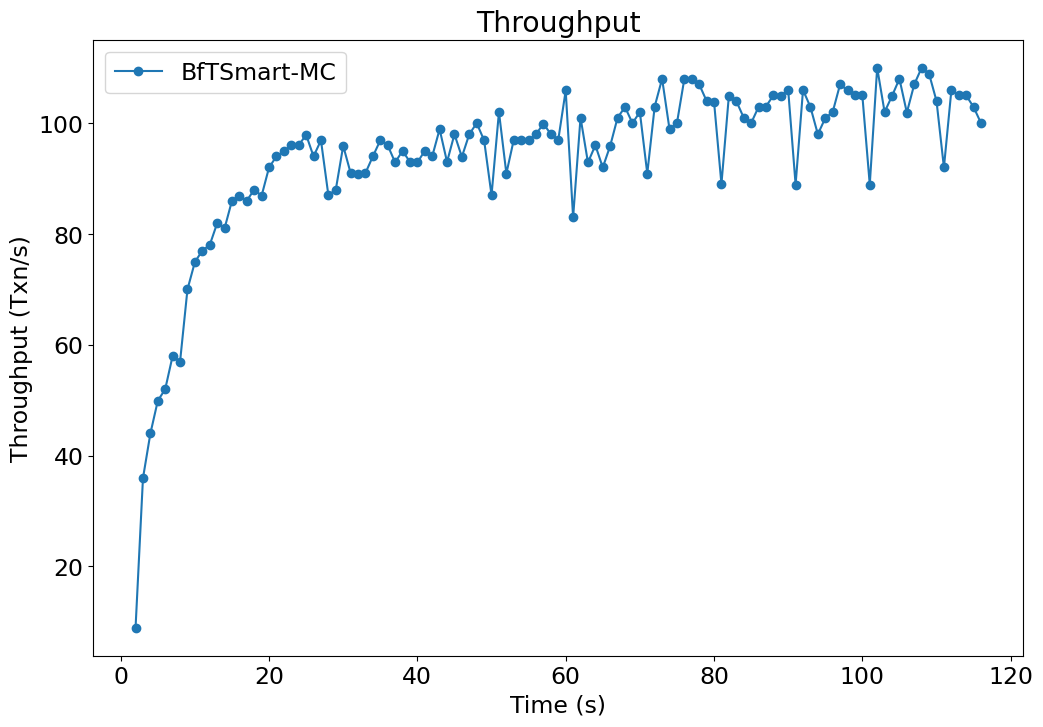

echo 1234 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem commands.sh ubuntu@ec2-50-18-227-20.us-west-1.compute.amazonaws.com:commands.sh
echo 1234 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem commands.sh ubuntu@ec2-54-177-218-23.us-west-1.compute.amazonaws.com:commands.sh
echo 1234 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem commands.sh ubuntu@ec2-18-144-31-30.us-west-1.compute.amazonaws.com:commands.sh
echo 1234 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem commands.sh ubuntu@ec2-54-241-187-86.us-west-1.compute.amazonaws.com:commands.sh
echo 1234 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem commands.sh ubuntu@ec2-3-101-83-7.us-west-1.compute.amazonaws.com:commands.sh
echo 1234 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem commands.sh ubuntu@ec2-54-241-187-106.us-west-1.comput

In [32]:
import pylab as pl

pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


pl.title(r'Throughput')


pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
pl.savefig('../Experiments/NormalRun.png', dpi = 150)
pl.show()

In [ ]:

def join_node1(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.24.233 11080 11081 config0 >../nohup_j1.out 2>&1 &"'
        
        
        os.system(command)   
        
        
def join_node2(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 9 172.31.19.58 11090 11091 config0 >../nohup_j2.out 2>&1 &"'
        
        
        os.system(command)
        
        
def join_node3(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 10 172.31.29.208 11100 11101 config0 >../nohup_j1.out 2>&1 &"'
        
        
        os.system(command)   
        
        
def join_node4(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 11 172.31.25.228 11110 11111 1 config1 >../nohup_j2.out 2>&1 &"'
        
        
        os.system(command)           

# join_node1(11), join_node2(11)

# time.sleep(30)
# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(45)
# print(results)  

# time.sleep(45)
# join_node1(11)
# time.sleep(45)

# join_node1(11)
# time.sleep(45)



print('XXXXXXXX Started Clients XXXXXXXXXXXX')

results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
time.sleep(85)



# join_node1(11)
# time.sleep(85)


# join_node2(11)
# time.sleep(85)




# results = Parallel(n_jobs=len(lines))(delayed(kill_clients)(i) for i in range(len(lines)))
# time.sleep(25)



# print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(20)


# def join_node1_check(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.24.46 11080 11081 config0 >../nohup_j1.out 2>&1 &"'
        
        
#         print(command)   
        

# join_node1_check(11)


# results = Parallel(n_jobs=len(lines))(delayed(kill_clients)(i) for i in range(len(lines)))
# time.sleep(5)


# join_node2(11)
# time.sleep(45)


# print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(45)




# join_node2(11)
# time.sleep(45)




# join_node3(13)
# time.sleep(40)
# join_node4(13)
# time.sleep(40)

# time.sleep(50)
check_node(10)

# time.sleep(100)

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

if not os.path.exists('../Experiments/'+experiment):
    os.mkdir('../Experiments/'+experiment)

for ip in nodeIps:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
#         print(command)
        os.system(command)

        
for ip in no_cluster_yet_nodes:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        

for ip in clientIps:    
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
        print(command)
        os.system(command)
        
        
        
for ip in clientIps:    
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
        print(command)
        os.system(command)
        
        
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j1.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j1.out'
        print(command)
        os.system(command)
        
        
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j2.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j2.out'
        print(command)
        os.system(command)        

## Byzantine Remote View Change

times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_c4_11.out')

import pylab as pl

pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


pl.title(r'Throughput with Byzantine Remote View Change ($nz$=8)')

# pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
pl.show()
pl.clf()


## Join End for Checking

times_all_clients = []
ops_all_clients = []
thputs_all_clients = []
latencies_all_clients = []


for ip in clientIps:
    print(lines.index(ip), nreplicas)
    
    
    with open('../Experiments/'+experiment+'/'+'nohup_c'+str(nreplicas)+'_'+str(lines.index(ip))+'.out') as f:
        data = f.readlines()
        
    
    

    times = []
    ops = []
    thputs = []
    latencies = []



    for line in data:
        if 'current ops/sec' in line:
    #         print(line)

            numbers_string = line.replace('sec:', ':').replace('operations;', ':').replace(\
                    'current ops/sec; [UPDATE AverageLatency(us)=', ':').replace('] \n', '').replace(' ','')

        
            if len(numbers_string.split(':')) == 4:

                times.append(float(numbers_string.split(':')[0]))
                ops.append(float(numbers_string.split(':')[1]))    
                thputs.append(float(numbers_string.split(':')[2]))    
                latencies.append(float(numbers_string.split(':')[3])/1e6)    



    times = np.array(times)
    ops = np.array(ops)
    thputs = np.array(thputs)
    latencies = np.array(latencies)
    
    times_all_clients.append(times)
    ops_all_clients.append(ops)    
    thputs_all_clients.append(thputs)    
    latencies_all_clients.append(latencies)    

times_all_clients


times_all_clients_final = []
ops_all_clients_final = []
thputs_all_clients_final = []
latencies_all_clients_final = []

for iter_, item in enumerate(times_all_clients):
    

    np.array(list(set(item).intersection(*times_all_clients[:])))
    # index = in1d(times_all_clients[0],a1)
    # result = a2[index]

    both = set(item).intersection(np.array(list(set(item).intersection(*times_all_clients[:]))))

    indices_A = [list(item).index(x) for x in list(both)]
    indices_B = [list(set(item).intersection(*times_all_clients[:])).index(x) for x in both]

    times_all_clients_final.append(item[indices_A])
    ops_all_clients_final.append(ops_all_clients[iter_][indices_A])
    thputs_all_clients_final.append(thputs_all_clients[iter_][indices_A])    
    latencies_all_clients_final.append(latencies_all_clients[iter_][indices_A])    

times_all = times_all_clients_final[0]
ops_all = sum(ops_all_clients_final)
thputs_all = sum(thputs_all_clients_final)
latencies_all = sum(latencies_all_clients_final)/len(latencies_all_clients_final)


print('Average Throughput is ',(ops_all[-1] - ops_all[59])/(times_all[-1] - times_all[59]))

print('Average Latency is', np.average(latencies_all[60:-10]))

times_all, thputs_all

# 40 client threads 2 delivery:93+95/81
# 100 client threads 2 delivery:124+129/81
# 100 client threads 8 delivery:138+138/81
# 40 client threads 8 delivery:95+95/81
# 40 client threads 16 delivery:97+96/81
# 40 client threads 16 delivery without IO:93+93/81
# 100 client threads 16 delivery without IO:146+149/81




(146+149)/81

check_node(0)

for i in [0,1, 4, 14, 15]:
# for i in [1]:
    
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../nohup_c4_'+str(i)+'.out'


        os.system(command)

## Join Experiment

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))



# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))



results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# print(results) 



results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# print(results)  

results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  



# time.sleep(30)
# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  


# time.sleep(80)
# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# for i in [0,1,4,8,12,13,14]:
# # for i in [1]:
    
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../nohup'+str(i)+'.out'


#         os.system(command)

check_node(11)

portStart = 11000 + len(nodeIps)*10

join_lines = []
currentPort = portStart

for i in range(len(no_cluster_yet_nodes)):
    line = str(len(nodeIps)+i) + ' ' + no_cluster_yet_nodes[i] + ' ' + str(currentPort) + ' '+ str(currentPort+1)
    currentPort = currentPort + 10
    join_lines.append(line)
    print('server',line)

./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.31.236 11080 11081 config0
./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 9 172.31.23.57 11090 11091 config1

## KILL ALL JAVA



results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
print(results)  

## JOIN COMMAND





def run_join_client(i):
    
    
    
    ip = lines[-2]
    if ip!='None':
        current = (ip.split('.'))
        
        join_commands = join_command(i)
        
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmarto; '+join_commands+'"'
        
        print(command)
        os.system(command)

## JOIN EXPERIMENT

check_node(3)

# t1 = time.time()
# time.sleep(3)
# t2 = time.time()

import time
JoinTimes = []


t_start = time.time()

results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
print(results)  

check_node(9)

time.sleep(40)

for i in range(4,8):
    print(i)
    JoinTimes.append(time.time() - t_start)
    run_join_client(i)
    time.sleep(40)
    

check_node(7)


results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
print(results)  

ip

ip = lines[-1]
if ip!='None':
    current = (ip.split('.'))
    command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
          +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out data/MultipleJoins/nohup.out'


    os.system(command)




import numpy as np
import pylab as pl

times ,thputs, lats = getTimesThputs('data/MultipleJoins/nohup.out')

JoinTimes

pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times[:-10], thputs[:-10], '-o', label='Existing nodes')


pl.title(r'Throughput with multiple join requests for Bft-Smart ($nz$=4)')

pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
pl.savefig('StatsPaper/fig10.png', dpi = 150)
pl.show()
pl.clf()



pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times[:-10], lats[:-10], '-o', label='Existing nodes')


pl.title(r'Latency with multiple join requests for Bft-Smart ($nz$=4)')

# pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

pl.xlabel('Time (s)')
# pl.ylabel(r'Latency ($\mu$s)')
pl.legend()
# pl.savefig('StatsPaper/fig10.png', dpi = 150)
pl.show()
pl.clf()

pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times[:-10], thputs[:-10]*lats[:-10], '-o', label='Existing nodes')


pl.title(r'Latency*thput with multiple join requests for Bft-Smart ($nz$=4)')

# pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

pl.xlabel('Time (s)')
pl.ylabel(r'Latency ($\mu$s)')
pl.legend()
# pl.savefig('StatsPaper/fig10.png', dpi = 150)
pl.show()
pl.clf()

## Random Failure

os.system('git add .; git commit -m "Fixed Failures and Joins";git push')

experiment = 'bjoin'


results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))


# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# print(results) 




results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# print(results)  

results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  


print('XXXXXXXX Started Servers XXXXXXXXXXXX')

time.sleep(40)

check_node(7)



def fail_node(i):
    ip = lines[i]
    if ip!='None' and ip in nodeIps:
        current = (ip.split('.'))
                
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo killall java"'
        
        print(command)
        os.system(command)

import numpy as np
import random

import time
# time.sleep(10)

FailTimes = []


t_start = time.time()

results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
print(results)  

check_node(9)

time.sleep(45)

for i in random.sample(list(np.arange(1)), 1):
    print(i)
    FailTimes.append(time.time() - t_start)
    fail_node(0)
    time.sleep(85)
    

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

ip = lines[-1]
if ip!='None':
    current = (ip.split('.'))
    command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
          +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/nohup.out'

    print(command)
    os.system(command)

FailTimes

times ,thputs, lats = getTimesThputs('../Experiments/nohup.out')

import pylab as pl

pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


pl.title(r'Throughput with single leader failure ($nz$=8)')

pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
# pl.savefig('../Experiments/fig6_leader.png', dpi = 150)
pl.show()
pl.clf()


if not os.path.exists('../Experiments/'+experiment):
    os.mkdir('../Experiments/'+experiment)

for ip in nodeIps:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
#         print(command)
        os.system(command)

        
for ip in no_cluster_yet_nodes:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        

for ip in clientIps:    
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
        print(command)
        os.system(command)
        
        
        
for ip in clientIps:    
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
        print(command)
        os.system(command)
        
        
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j1.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j1.out'
        print(command)
        os.system(command)
        
        
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j2.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j2.out'
        print(command)
        os.system(command)        

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))